In [1]:
# %% [code] Set Working Directory and Patch Dummy Modules / Transformers

import sys, types

# Dummy for fairseq
dummy_fairseq = types.ModuleType("fairseq")
dummy_fairseq.optim = types.ModuleType("fairseq.optim")
dummy_fairseq.optim.build_optimizer = lambda args, params: None
dummy_fairseq.optim.lr_scheduler = types.ModuleType("fairseq.optim.lr_scheduler")
dummy_fairseq.optim.lr_scheduler.build_lr_scheduler = lambda args, optimizer: None
sys.modules["fairseq"] = dummy_fairseq
print("Injected dummy fairseq module.")

# Dummy for fastDamerauLevenshtein
def damerau_levenshtein_distance(s1, s2):
    len_s1, len_s2 = len(s1), len(s2)
    d = [[0] * (len_s2 + 1) for _ in range(len_s1 + 1)]
    for i in range(len_s1 + 1):
        d[i][0] = i
    for j in range(len_s2 + 1):
        d[0][j] = j
    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            d[i][j] = min(
                d[i-1][j] + 1,
                d[i][j-1] + 1,
                d[i-1][j-1] + cost
            )
            # optional transposition
            if i > 1 and j > 1 and s1[i-1] == s2[j-2] and s1[i-2] == s2[j-1]:
                d[i][j] = min(d[i][j], d[i-2][j-2] + cost)
    return d[len_s1][len_s1]

dummy_fast = types.ModuleType("fastDamerauLevenshtein")
dummy_fast.damerauLevenshtein = damerau_levenshtein_distance
sys.modules["fastDamerauLevenshtein"] = dummy_fast
print("Injected dummy fastDamerauLevenshtein module.")

# Patch transformers.generation_utils
import transformers
dummy_generation_utils = types.ModuleType("generation_utils")
def dummy_top_k_top_p_filtering(logits, top_k=0, top_p=1.0, filter_value=-float("Inf")):
    return logits
dummy_generation_utils.top_k_top_p_filtering = dummy_top_k_top_p_filtering
setattr(transformers, "generation_utils", dummy_generation_utils)
sys.modules["transformers.generation_utils"] = dummy_generation_utils
print("Patched transformers.generation_utils with dummy top_k_top_p_filtering function.")

import logging
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", 
    level=logging.INFO
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


Injected dummy fairseq module.
Injected dummy fastDamerauLevenshtein module.
Patched transformers.generation_utils with dummy top_k_top_p_filtering function.


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Dataset for TypoTransformer
"""

import os
import re
import csv
import torch
import multiprocessing
import random
import json
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader, IterableDataset
import logging


logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    level=logging.INFO  # Only INFO and above will be shown.
)
logger = logging.getLogger(__name__)

from utils.mimic_tools import MIMICPseudonymizer
from scripts.utils import sanitize_text, clean_text
from fastDamerauLevenshtein import damerauLevenshtein

DEFAULT_MAX_CHARACTER_POSITIONS = 64
char_tokens = list(r"0123456789abcdefghijklmnopqrstuvwxyz+-*/^.,;:=!?'()[]{}&")


###############################################################################
# CharTokenizer
###############################################################################
class CharTokenizer(object):
    """
    A simple character-level tokenizer with optional BOS/EOS/pad tokens.
    """
    def __init__(self, max_length=DEFAULT_MAX_CHARACTER_POSITIONS):
        self.max_length = max_length
        self.bos, self.pad, self.eos, self.unk = ['<s>', '<pad>', '</s>', '<unk>']
        self.bos_index, self.pad_index, self.eos_index, self.unk_index = 0, 1, 2, 3

        # Build char_to_id / id_to_char for special tokens + characters.
        self.char_to_id = {}
        self.id_to_char = {}
        special_tokens = [self.bos, self.pad, self.eos, self.unk]
        for i, c in enumerate(special_tokens + char_tokens):
            self.char_to_id[c] = i
            self.id_to_char[i] = c

    def tokenize(self, text, eos_bos=True, padding_end=False, max_length=None, output_token_ids=False):
        """
        Tokenize text at the character level.
        - eos_bos: whether to prepend <s> and append </s>.
        - padding_end: whether to pad the sequence to a fixed length.
        - max_length: override default if needed.
        - output_token_ids: if True, return (token_ids, attention_mask);
          otherwise return (tokens, attention_mask).
        """
        assert isinstance(text, str)
        if max_length is None:
            max_length = self.max_length
        max_seq_len = max_length - 2 if eos_bos else max_length
        tokens = []
        attention_mask = []

        # Convert characters up to max_seq_len
        for char in text[:max_seq_len]:
            tokens.append(char if char in self.char_to_id else self.unk)
            attention_mask.append(1)


        if eos_bos:
            tokens.insert(0, self.bos)
            tokens.append(self.eos)
            attention_mask.insert(0, 1)
            attention_mask.append(1)


        if padding_end:
            pad_len = max_length - len(tokens)
            tokens.extend([self.pad] * pad_len)
            attention_mask.extend([0] * pad_len)

        if output_token_ids:
            token_ids = self.convert_tokens_to_ids(tokens)
            return token_ids, attention_mask
        return tokens, attention_mask

    def convert_tokens_to_ids(self, tokens):
        return [self.char_to_id[t] for t in tokens]

    def convert_ids_to_tokens(self, ids):
        if isinstance(ids, torch.Tensor):
            ids = ids.cpu().detach().tolist()
        return [self.id_to_char[i] for i in ids]


###############################################################################
# Map-style Dataset (for validation/test)
###############################################################################
class TypoDataset(Dataset):
    """
    This dataset gives examples of (typo, context, correction).
    """
    def __init__(self, tsv_file, bert_tokenizer, typo_tokenizer, num_process=None, max_rows=None):
        assert os.path.exists(tsv_file), f'{tsv_file} does not exist'
        self.tsv_file = tsv_file
        self.bert_tokenizer = bert_tokenizer
        self.typo_tokenizer = typo_tokenizer

        print(f"Read file {tsv_file}... ", end="", flush=True)
        self.csv_rows = []
        with open(self.tsv_file, "r", encoding="utf-8", errors="replace") as fd:
            reader = csv.reader(fd, delimiter="\t")
            for i, row in enumerate(reader):
                if i == 0:  # skip header
                    continue
                self.csv_rows.append(row)
                if max_rows is not None and len(self.csv_rows) >= max_rows:
                    break
        print(f"{len(self.csv_rows)} rows")

        if num_process is None:
            num_process = multiprocessing.cpu_count()
        num_process = min(num_process, len(self.csv_rows))
        print(f"Parsing rows using {num_process} process{'es' if num_process > 1 else ''}")

        self.examples = []
        fixed_chunksize = 100

        if num_process == 1:
            for row in tqdm(self.csv_rows, total=len(self.csv_rows)):
                self.examples.append(self._parse_row(row))
        else:
            pool = multiprocessing.Pool(num_process)
            for example in tqdm(pool.imap(self._parse_row, self.csv_rows, chunksize=fixed_chunksize),
                                total=len(self.csv_rows)):
                self.examples.append(example)
            pool.close()
            pool.join()

    def _make_sentence(self, tokens_left, tokens_right, seq_length=128):
        len_left = len(tokens_left)
        len_right = len(tokens_right)
        cut_len = len_left + len_right - (seq_length - 1)
        if cut_len > 0:
            cut_left = len_left - seq_length // 2
            cut_right = len_right - (seq_length - 1) // 2
            if cut_left < 0:
                cut_left, cut_right = 0, cut_left + cut_right
            elif cut_right < 0:
                cut_left, cut_right = cut_left + cut_right, 0
        else:
            cut_left, cut_right = 0, 0

        tokens_left = tokens_left[cut_left:]
        tokens_right = tokens_right[:len(tokens_right) - cut_right]
        tokens = tokens_left + [self.bert_tokenizer.mask_token] + tokens_right
        attention_mask = [1] * len(tokens_left) + [1] + [1] * len(tokens_right)

        if len(tokens) < seq_length:
            pad_len = seq_length - len(tokens)
            tokens.extend([self.bert_tokenizer.pad_token] * pad_len)
            attention_mask.extend([0] * pad_len)
        return tokens, attention_mask

    def _parse_row(self, row):
        """
        Convert a CSV row to an example.
        Expected format: [ex_id, note_id, typo, left, right, correct]
        """
        ex_id, note_id, typo, left, right, correct = row
        tokens_left = self.bert_tokenizer.tokenize(left)
        tokens_right = self.bert_tokenizer.tokenize(right)
        context_tokens, context_attention_mask = self._make_sentence(tokens_left, tokens_right)
        context_token_ids = self.bert_tokenizer.convert_tokens_to_ids(context_tokens)

        typo_token_ids, typo_attention_mask = self.typo_tokenizer.tokenize(
            typo, eos_bos=True, padding_end=False, output_token_ids=True)
        correct_token_ids, correct_attention_mask = self.typo_tokenizer.tokenize(
            correct, eos_bos=True, padding_end=False, output_token_ids=True)

        return {
            'example_id': int(ex_id),
            'note_id': int(note_id),
            'context_tokens': context_token_ids,
            'context_attention_mask': context_attention_mask,
            'typo': typo,
            'typo_token_ids': typo_token_ids,
            'typo_attention_mask': typo_attention_mask,
            'correct': correct,
            'correct_token_ids': correct_token_ids,
            'correct_attention_mask': correct_attention_mask
        }

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, index):
        return self.examples[index]

    def get_collate_fn(self, stack=True):
        def _collate_fn(examples):
            max_typo_len = max(len(e['typo_token_ids']) for e in examples)
            max_correct_len = max(len(e['correct_token_ids']) for e in examples)
            common_len = max(max_typo_len, max_correct_len) + 1
            for e in examples:
                e['typo_token_ids'] = e['typo_token_ids'] + [self.typo_tokenizer.pad_index] * (common_len - len(e['typo_token_ids']))
                e['typo_attention_mask'] = e['typo_attention_mask'] + [0] * (common_len - len(e['typo_attention_mask']))
                e['correct_token_ids'] = e['correct_token_ids'] + [self.typo_tokenizer.pad_index] * (common_len - len(e['correct_token_ids']))
                e['correct_attention_mask'] = e['correct_attention_mask'] + [0] * (common_len - len(e['correct_attention_mask']))
            if stack:
                batch = {}
                for key in examples[0].keys():
                    if key in ['typo', 'correct', 'left_context', 'right_context']:
                        batch[key] = [e[key] for e in examples]
                    else:
                        batch[key] = torch.tensor([e[key] for e in examples])
                return batch
            else:
                return examples
        return _collate_fn


###############################################################################
# Iterable (Streaming) Dataset
###############################################################################
class TypoOnlineDataset(IterableDataset):
    """
    This streaming dataset reads from multiple CSV files at random.
    It sums the rows from all CSV files for its __len__.
    """
    def __init__(self, csv_dir, dict_file, bert_tokenizer, typo_tokenizer,
                 max_word_corruptions=3, do_substitution=True, do_transposition=True,
                 no_corruption_prob=0.0, min_word_len=3):
        super().__init__()
        self.csv_dir = csv_dir
        self.csv_fnames = [f for f in os.listdir(self.csv_dir)
                           if f.startswith('NOTEEVENTS') and f.endswith('.csv')]
        self.dict_file = dict_file
        with open(self.dict_file, 'r') as fd:
            self.dictionary = set(json.load(fd))
        self.bert_tokenizer = bert_tokenizer
        self.typo_tokenizer = typo_tokenizer

        self.max_word_corruptions = max_word_corruptions
        self.do_substitution = do_substitution
        self.do_transposition = do_transposition
        self.word_corrupter = WordCorrupter(self.max_word_corruptions,
                                            self.do_substitution,
                                            self.do_transposition)
        self.no_corruption_prob = no_corruption_prob
        self.min_word_len = min_word_len

        mimic_tools_dir = 'scripts/mimic-tools/lists'
        self.mimic_pseudo = MIMICPseudonymizer(mimic_tools_dir)

        self.total_samples = self._count_total_rows()

    def get_collate_fn(self, stack=True):
        return TypoDataset.get_collate_fn(self)

    def _count_total_rows(self):
        total = 0
        for fname in self.csv_fnames:
            csv_path = os.path.join(self.csv_dir, fname)
            try:
                df = pd.read_csv(csv_path, low_memory=False)
                total += len(df)
            except Exception as e:
                logger.error(f"Error reading {csv_path}: {e}")
        return total

    def __len__(self):
        return self.total_samples

    def _load_random_csv(self):
        self.csv_fname = random.choice(self.csv_fnames)
        self.csv_path = os.path.join(self.csv_dir, self.csv_fname)
        self.df_note = pd.read_csv(self.csv_path, low_memory=False)
        self.note_iterrows = self.df_note.iterrows()

    def _make_sentence(self, tokens_left, tokens_right, seq_length=128):
        len_left = len(tokens_left)
        len_right = len(tokens_right)
        cut_len = len_left + len_right - (seq_length - 1)
        if cut_len > 0:
            cut_left = len_left - seq_length // 2
            cut_right = len_right - (seq_length - 1) // 2
            if cut_left < 0:
                cut_left, cut_right = 0, cut_left + cut_right
            elif cut_right < 0:
                cut_left, cut_right = cut_left + cut_right, 0
        else:
            cut_left, cut_right = 0, 0

        tokens_left = tokens_left[cut_left:]
        tokens_right = tokens_right[:len(tokens_right) - cut_right]
        tokens = tokens_left + [self.bert_tokenizer.mask_token] + tokens_right
        attention_mask = [1] * len(tokens_left) + [1] + [1] * len(tokens_right)
        if len(tokens) < seq_length:
            pad_len = seq_length - len(tokens)
            tokens.extend([self.bert_tokenizer.pad_token] * pad_len)
            attention_mask.extend([0] * pad_len)
        return tokens, attention_mask

    def _parse_row(self, row):
        """
        Updated _parse_row for streaming examples.
        Expected row format: [ex_id, note_id, typo, left, right, correct]
        """
        ex_id, note_id, typo, left, right, correct = row
        tokens_left = self.bert_tokenizer.tokenize(left)
        tokens_right = self.bert_tokenizer.tokenize(right)
        context_tokens, context_attention_mask = self._make_sentence(tokens_left, tokens_right)
        context_token_ids = self.bert_tokenizer.convert_tokens_to_ids(context_tokens)

        typo_token_ids, typo_attention_mask = self.typo_tokenizer.tokenize(
            typo, eos_bos=True, padding_end=False, output_token_ids=True)
        correct_token_ids, correct_attention_mask = self.typo_tokenizer.tokenize(
            correct, eos_bos=True, padding_end=False, output_token_ids=True)

        return {
            "example_id": ex_id,
            "note_id": note_id,
            "context_tokens": context_token_ids,
            "context_attention_mask": context_attention_mask,
            "typo": typo,
            "typo_token_ids": typo_token_ids,
            "typo_attention_mask": typo_attention_mask,
            "left_context": left,
            "right_context": right,
            "correct": correct,
            "correct_token_ids": correct_token_ids,
            "correct_attention_mask": correct_attention_mask
        }

    def __iter__(self):
        self._load_random_csv()
        return self

    def __next__(self):
        while True:
            try:
                _, row = next(self.note_iterrows)
            except StopIteration:
                self._load_random_csv()
                _, row = next(self.note_iterrows)
            note_id = int(row.ROW_ID)
            note = row.TEXT.strip()
            if len(note) < 500:
                continue
            try:
                correct, left, right = self._random_word_context(note)
            except Exception:
                continue
            break

        correct = correct.lower()
        typo = self.word_corrupter.corrupt_word(correct) if random.uniform(0, 1) >= self.no_corruption_prob else correct
        left = self.mimic_pseudo.pseudonymize(left)
        left = self._process_note(left)
        left = ' '.join(left.split(' ')[-128:])
        right = self.mimic_pseudo.pseudonymize(right)
        right = self._process_note(right)
        right = ' '.join(right.split(' ')[:128])
        temp_csv_row = [-1, note_id, typo, left, right, correct]
        return self._parse_row(temp_csv_row)

    def _count_total_rows(self):
        total = 0
        for fname in self.csv_fnames:
            csv_path = os.path.join(self.csv_dir, fname)
            try:
                df = pd.read_csv(csv_path, low_memory=False)
                total += len(df)
            except Exception as e:
                logger.error(f"Error reading {csv_path}: {e}")
        return total

    def _random_word_context(self, text, max_trial=10):
        """
        Quietly tries up to max_trial times to find a suitable word in the text.
        """
        words = text.split()
        trial = 0
        while trial < max_trial and words:
            trial += 1
            word = words[0]
            if (len(word) >= self.min_word_len and 
                word.lower() in self.dictionary and 
                len(word) < DEFAULT_MAX_CHARACTER_POSITIONS - 4):
                left_context = " ".join(words[:1])
                right_context = " ".join(words[1:])
                return word, left_context, right_context
            else:
                words = words[1:]
        return "default", "", ""

    def _process_note(self, note):
        note = re.sub('\n', ' ', note)
        note = re.sub('\t', ' ', note)
        return sanitize_text(clean_text(note))


###############################################################################
# Utility: WordCorrupter
###############################################################################
class WordCorrupter(object):
    def __init__(self, max_corruptions=2, do_substitution=True, do_transposition=True):
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
        self.max_corruptions = max_corruptions
        self.do_substitution = do_substitution
        self.do_transposition = do_transposition
        self.operation_list = ['ins', 'del']
        if self.do_substitution:
            self.operation_list.append('sub')
        if self.do_transposition:
            self.operation_list.append('tra')

    def random_alphabet(self):
        return random.choice(self.alphabet)

    def single_corruption(self, word):
        while True:
            oper = random.choice(self.operation_list)
            if oper == "del":
                if len(word) == 1:
                    continue
                cidx = random.randint(0, len(word) - 1)
                ret = word[:cidx] + word[cidx+1:]
                break
            elif oper == "ins":
                cidx = random.randint(0, len(word))
                ret = word[:cidx] + self.random_alphabet() + word[cidx:]
                break
            elif oper == "sub":
                cidx = random.randint(0, len(word) - 1)
                while True:
                    c = self.random_alphabet()
                    if c != word[cidx]:
                        ret = word[:cidx] + c + word[cidx+1:]
                        break
                break
            elif oper == "tra":
                if len(word) == 1:
                    continue
                cidx = random.randint(0, len(word) - 2)
                if word[cidx+1] == word[cidx]:
                    continue
                ret = word[:cidx] + word[cidx+1] + word[cidx] + word[cidx+2:]
                break
            else:
                raise ValueError(f'Wrong operation {oper}')
        return ret

    def corrupt_word(self, word_original):
        num_corruption = random.randint(1, self.max_corruptions)
        while True:
            word = word_original
            for _ in range(num_corruption):
                word = self.single_corruption(word)
            if word_original != word:
                break
        return word


logger.info("Character Language Model and related classes defined successfully.")

2025-04-19 00:52:28,829 - __main__ - INFO - Character Language Model and related classes defined successfully.


In [5]:
from transformers.generation.utils import GenerationMixin
from transformers.models.bart.modeling_bart import BartDecoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import multiprocessing

char_tokens = list(r"0123456789abcdefghijklmnopqrstuvwxyz+-*/^.,;:=!?'()[]{}&")
special_tokens_fairseq = ['<s>', '<pad>', '</s>', '<unk>']

DEFAULT_MAX_CHARACTER_POSITIONS = 64

def my_prepare_bart_decoder_inputs(
    config,
    input_ids,
    decoder_input_ids=None,
    decoder_padding_mask=None,
    causal_mask_dtype=torch.float32,
    pad_token_id=1
):
    """
    Helper function to do manual BART-style causal masking.
    """
    if decoder_input_ids is None:
        decoder_input_ids = input_ids
    bsz, tgt_len = decoder_input_ids.shape
    causal_mask = torch.full(
        (tgt_len, tgt_len), float("-inf"), dtype=causal_mask_dtype, device=decoder_input_ids.device
    )
    causal_mask = causal_mask.triu(1)
    causal_mask = causal_mask.unsqueeze(0).unsqueeze(1).expand(bsz, 1, tgt_len, tgt_len)

    if decoder_padding_mask is None:
        decoder_padding_mask = decoder_input_ids.eq(pad_token_id)

    return decoder_input_ids, decoder_padding_mask, causal_mask

def my_make_linear_from_emb(embed_tokens):
    """
    Create a linear layer whose weights tie to the given embedding matrix.
    """
    weight = embed_tokens.weight
    out_dim, in_dim = weight.shape
    linear = nn.Linear(in_dim, out_dim, bias=False)
    with torch.no_grad():
        linear.weight.copy_(weight)
    return linear

class CharacterLanguageModel(transformers.BartPreTrainedModel, GenerationMixin):
    """
    A custom BERT encoder + BartDecoder model for character-level correction.
    """
    def __init__(self, args, config, bert_model, char_decoder):
        super().__init__(config)
        self.args = args
        self.config = config

        # Final bias for vocabulary projection
        self.final_logits_bias = nn.Parameter(torch.zeros(1, self.config.vocab_size))

        # Our BERT-based encoder is inside 'bert_model.bert'
        self.encoder = bert_model.bert
        
        # Our BartDecoder for the character-level decoding
        self.decoder = char_decoder

        # Optionally freeze BERT
        self.train_bert = args.train_bert
        if not self.train_bert:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.bos, self.pad, self.eos, self.unk = special_tokens_fairseq

        # Edit-distance pools (used if you have custom ED logic, can remove if not used)
        self.ed_pool_master = multiprocessing.pool.ThreadPool(processes=1)
        self.ed_pool_worker = multiprocessing.Pool(processes=4)

    def get_param_group(self, finetune_bert=False, finetune_factor=0.1):
        """
        Return param groups with different LR factors if fine-tuning BERT is desired.
        """
        if not finetune_bert:
            return [{'params': list(self.parameters()), 'lr_factor': 1.0}]
        else:
            bert_params = list(self.encoder.parameters())
            bert_params_set = set(bert_params)
            other_params = [p for p in self.parameters() if p not in bert_params_set]
            return [
                {'params': other_params, 'lr_factor': 1.0},
                {'params': bert_params, 'lr_factor': finetune_factor}
            ]

    @classmethod
    def get_bert_config(cls, bert_config_file):
        with open(bert_config_file, 'r') as fd:
            config_orig = json.load(fd)
        bert_config = transformers.BertConfig(
            vocab_size=config_orig['vocab_size'],
            hidden_size=config_orig['hidden_size'],
            num_hidden_layers=config_orig['num_hidden_layers'],
            num_attention_heads=config_orig['num_attention_heads'],
            intermediate_size=config_orig['intermediate_size'],
            hidden_act=config_orig['hidden_act'],
            hidden_dropout_prob=config_orig['hidden_dropout_prob'],
            attention_probs_dropout_prob=config_orig['attention_probs_dropout_prob'],
            max_position_embeddings=config_orig['max_position_embeddings'],
            type_vocab_size=config_orig['type_vocab_size'],
            initializer_range=config_orig['initializer_range'],
            layer_norm_eps=1e-12
        )
        return bert_config

    @classmethod
    def build_bert_model(cls, bert_config):
        """
        Build a BertForPreTraining model from the config
        (We only use the 'bert' submodule for the encoder).
        """
        return transformers.BertForPreTraining(bert_config)

    @classmethod
    def get_bert_tokenizer(cls, bert_vocab_file):
        """
        Return a standard HF BertTokenizer from the provided vocab file.
        """
        return transformers.BertTokenizer(
            bert_vocab_file,
            do_lower_case=True,
            do_basic_tokenize=True
        )

    @classmethod
    def get_char_embeddings_from_bert(cls, bert_embeddings, bert_tokenizer):
        """
        Create a new nn.Embedding for only the char tokens we care about
        (special + '0123456...z' etc.) from the full BERT embedding matrix.
        """
        char_word_ids = [
            bert_tokenizer.cls_token_id,
            bert_tokenizer.pad_token_id,
            bert_tokenizer.sep_token_id,
            bert_tokenizer.unk_token_id
        ]
        char_word_ids.extend(bert_tokenizer.convert_tokens_to_ids(char_tokens))

        # If bert_embeddings is an nn.Embedding
        if isinstance(bert_embeddings, nn.Embedding):
            embedding_matrix = bert_embeddings(torch.tensor(char_word_ids)).detach()
        # If it is a tensor
        elif isinstance(bert_embeddings, torch.Tensor):
            embedding_matrix = bert_embeddings[char_word_ids, :].detach()
        else:
            raise ValueError("Unsupported embedding type for get_char_embeddings_from_bert")

        return nn.Embedding.from_pretrained(
            embedding_matrix,
            freeze=False,      # allow fine-tuning
            padding_idx=1      # index 1 = <pad>
        )

    @classmethod
    def get_char_decoder_config(cls, bert_config_file, args):
        """
        Build a BartConfig for the decoder, matching the BERT hidden size, etc.
        """
        with open(bert_config_file, 'r') as fd:
            config_orig = json.load(fd)
        return transformers.BartConfig(
            is_decoder=True,
            vocab_size=len(char_tokens) + len(special_tokens_fairseq),
            d_model=config_orig['hidden_size'],
            decoder_layers=args.decoder_layers,
            max_position_embeddings=DEFAULT_MAX_CHARACTER_POSITIONS,
            init_str=config_orig['initializer_range']  # can be used for init if you want
        )

    @classmethod
    def build_char_decoder(cls, bart_config, char_embedding):
        """
        Create a BartDecoder using our char_embedding as the input embeddings.
        """
        return BartDecoder(bart_config, char_embedding)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        target_correct=None,
        encoder_outputs=None,
        encoder_embeds=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs
    ):
        """
        Forward pass for the BERT encoder + BartDecoder architecture.
        """
        # If encoder_embeds is passed, skip re-encoding
        if encoder_embeds is not None:
            encoder_outputs = (encoder_embeds,)

        # 1) Encode with BERT if needed
        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict
            )

        # 2) If caller didn't supply decoder inputs or masks
        if decoder_input_ids is None and 'input_ids_correct' in kwargs:
            decoder_input_ids = kwargs['input_ids_correct']
        if decoder_attention_mask is None and 'attention_mask_correct' in kwargs:
            decoder_attention_mask = kwargs['attention_mask_correct']

        # 3) Decode with BartDecoder
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_outputs[0],   
            encoder_attention_mask=attention_mask,       
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=True   
        )

        # 4) Project the decoder outputs to the vocab
        lm_output_logits = F.linear(
            decoder_outputs[0],               
            self.decoder.embed_tokens.weight,  
            bias=self.final_logits_bias
        )

        # *** Return the entire Seq2SeqLMOutput *** 
        # pass through `past_key_values` so beam search can do fast decoding
        return transformers.modeling_outputs.Seq2SeqLMOutput(
            logits=lm_output_logits,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states if output_hidden_states else None,
            decoder_attentions=decoder_outputs.attentions if output_attentions else None,
        )

    def get_encoder(self):
        """
        Return the BERT encoder for convenience.
        """
        return self.encoder

    def get_output_embeddings(self):
        """
        For generation: tie the final linear layer to self.decoder.embed_tokens
        """
        return my_make_linear_from_emb(self.decoder.embed_tokens)

    def prepare_inputs_for_generation(
        self,
        decoder_input_ids,
        past=None,
        attention_mask=None,
        use_cache=None,
        encoder_outputs=None,
        **kwargs
    ):
        """
       return a dict of standard names that match `forward()`:
         - input_ids / attention_mask / decoder_input_ids / (etc.)
        By default, we won't re-encode if `encoder_outputs` is given.
        """
        return {
            "input_ids": None,              
            "attention_mask": attention_mask,
            "decoder_input_ids": decoder_input_ids,
            "encoder_outputs": encoder_outputs,
            "past_key_values": past,
            "use_cache": use_cache,
        }

    def adjust_logits_during_generation(self, logits, cur_len, max_length):
        """
        Optionally modify the logits at each generation step
        """
        if cur_len == 1 and self.config.force_bos_token_to_be_generated:
            self._force_token_id_to_be_generated(logits, self.config.bos_token_id)
        elif cur_len == max_length - 1 and self.config.eos_token_id is not None:
            self._force_token_id_to_be_generated(logits, self.config.eos_token_id)
        return logits

    @staticmethod
    def _force_token_id_to_be_generated(scores, token_id) -> None:
        """
        Utility for forcibly setting the distribution to only the 'token_id' argument.
        """
        scores[:, [x for x in range(scores.shape[1]) if x != token_id]] = float("-inf")

    def _reorder_cache(self, past_key_values, beam_idx):
        """
        Required for beam search so it can reorder the `past_key_values` after each step.
        We'll reorder dimension 0  according to beam_idx for each layer.
        """
        if past_key_values is None:
            return past_key_values

        reordered_past = []
        for layer_past in past_key_values:
            if layer_past is None:
                reordered_past.append(None)
                continue


            reordered_layer_past = tuple(
                past_state.index_select(0, beam_idx) for past_state in layer_past
            )
            reordered_past.append(reordered_layer_past)

        return tuple(reordered_past)

    def parameters(self):
        """
        HF compat: override if needed to handle weird param listing.
        """
        if len(list(super().parameters())):
            return super().parameters()
        elif hasattr(self, "_former_parameters"):
            return (p for m in self.modules() for p in m._former_parameters.values())
        elif hasattr(self, "_parameters"):
            return (p for m in self.modules() for p in m._parameters.values())

    @staticmethod
    def get_set_lr():
        """
        Utility for custom LR scheduling, if code calls it.
        """
        def set_lr(self, lr):
            for param_group in self.optimizer.param_groups:
                if 'lr_factor' in param_group:
                    param_group['lr'] = lr * param_group['lr_factor']
                else:
                    param_group['lr'] = lr
        return set_lr

In [6]:
import sys, time, pickle, random
from datetime import datetime
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from torch.utils.tensorboard import SummaryWriter
from types import SimpleNamespace

args = SimpleNamespace(
    mimic_csv_dir="data/mimic3/split",
    data_dir="data/mimic_synthetic",
    dict_file="data/lexicon/lexicon.json",
    bert_dir="C:\\Users\\Nick Chen\\Desktop\\FinalP2\\cim-misspelling-main\\bert\\ncbi_bert_base",
    output_dir="results/cim_base",
    is_train=True,
    test_file="test.tsv",
    init_ckpt=None,
    init_step=0,
    seed=123,
    decoder_layers=12,
    train_bert=True,
    bert_finetune_factor=1.0,
    dropout=0.1,
    synthetic_min_word_len=3,
    do_substitution=True,
    do_transposition=True,
    max_word_corruptions=3,
    no_corruption_prob=0.1,
    train_with_ed=False,
    atch_size=256,
    num_gpus=1,
    optimizer='adam',
    adam_betas="(0.9, 0.999)",
    adam_eps=1e-08,
    weight_decay=0.01,
    training_step=60000,
    display_iter=500,
    eval_iter=5000,
    lr=[3e-4],
    warmup_updates=4000,
    warmup_init_lr=1e-6,
    num_beams=5,
    edit_distance_weight=5.0,
    edit_distance_extra_len=100,
    length_penalty=1.0,
    beam_sort_linear_ed=False,
    beam_final_score_normalize_ed=False,
    dict_matching=True
)

for k, v in vars(args).items():
    print(f"{k}: {v}")

torch.backends.cudnn.benchmark = True
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
random.seed(args.seed)

# Re-save TSV File with UTF-8 Encoding
import csv
input_path = r"C:\Users\Nick Chen\Desktop\FinalP2\cim-misspelling-main\data\mimic_synthetic\all.tsv"
output_path = r"C:\Users\Nick Chen\Desktop\FinalP2\cim-misspelling-main\data\mimic_synthetic\all_fixed.tsv"
with open(input_path, 'r', encoding='cp1252', errors='replace') as fin, \
     open(output_path, 'w', encoding='utf-8', newline='') as fout:
    reader = csv.reader(fin, delimiter='\t')
    writer_csv = csv.writer(fout, delimiter='\t')
    for row in reader:
        writer_csv.writerow(row)
print("Re-saved TSV file to UTF-8 as:", output_path)

from utils.checkpoint_manager import CheckPointManager

bert_config_file = os.path.join(args.bert_dir, "bert_config.json")
bert_config = CharacterLanguageModel.get_bert_config(bert_config_file)
char_decoder_config = CharacterLanguageModel.get_char_decoder_config(bert_config_file, args)

bert_vocab_file = os.path.join(args.bert_dir, "vocab.txt")
bert_tokenizer = CharacterLanguageModel.get_bert_tokenizer(bert_vocab_file)

# Build the custom CharTokenizer 
# from data.dataset import CharTokenizer  
typo_tokenizer = CharTokenizer()



print("Seed, BERT configuration, and tokenizers set up successfully.")

# Build the BERT model
bert_model = CharacterLanguageModel.build_bert_model(bert_config)
bert_tf_file = os.path.join(args.bert_dir, "bert_model.ckpt")
print("Loading TensorFlow weights into BERT model...")
bert_model.load_tf_weights(config=bert_config, tf_checkpoint_path=bert_tf_file)
print("BERT weights loaded successfully.")

# Build the character decoder
print("Creating character embeddings from BERT model...")
char_embeddings_decoder = CharacterLanguageModel.get_char_embeddings_from_bert(
    bert_model.cls.predictions.decoder.weight, 
    bert_tokenizer
)
char_decoder = CharacterLanguageModel.build_char_decoder(char_decoder_config, char_embeddings_decoder)

# Build the full CharacterLanguageModel
print("Building full CharacterLanguageModel...")
model = CharacterLanguageModel(args, char_decoder_config, bert_model, char_decoder)
# Make sure your model is recognized as an encoder-decoder:
model.config.is_encoder_decoder = True


model.config.bos_token_id = 0
model.config.pad_token_id = 1
model.config.eos_token_id = 2
model.config.unk_token_id = 3


model.config.decoder_start_token_id = 0

# Make sure config matches the total number of char tokens
model.config.vocab_size = len(typo_tokenizer.char_to_id)

print("Full CharacterLanguageModel built successfully.")

ckpt_manager = CheckPointManager(args.output_dir)
init_step = args.init_step
if args.init_ckpt is not None:
    print(f"Loading model checkpoint from {args.init_ckpt} (step {args.init_step})")
    model.load_state_dict(torch.load(args.init_ckpt))
    init_step = args.init_step
else:
    ckpt_status = ckpt_manager.get_latest_checkpoint()
    if ckpt_status:
        init_step, ckpt_fname = ckpt_status
        ckpt_fpath = os.path.join(args.output_dir, ckpt_fname)
        print(f"Loading model checkpoint from {ckpt_fpath} (step {init_step})")
        ckpt_manager.load_ckpt(model, ckpt_fname)

global_step = init_step
if global_step == 0:
    ckpt_manager.save_args(args)
print("Model initialization and checkpoint loading complete.")

available_gpus = torch.cuda.device_count()
args.num_gpus = min(args.num_gpus, available_gpus)

if args.num_gpus > 1:
    model_train = torch.nn.DataParallel(model, device_ids=list(range(args.num_gpus)))
else:
    model_train = model

print("Model setup complete.")


mimic_csv_dir: data/mimic3/split
data_dir: data/mimic_synthetic
dict_file: data/lexicon/lexicon.json
bert_dir: C:\Users\Nick Chen\Desktop\FinalP2\cim-misspelling-main\bert\ncbi_bert_base
output_dir: results/cim_base
is_train: True
test_file: test.tsv
init_ckpt: None
init_step: 0
seed: 123
decoder_layers: 12
train_bert: True
bert_finetune_factor: 1.0
dropout: 0.1
synthetic_min_word_len: 3
do_substitution: True
do_transposition: True
max_word_corruptions: 3
no_corruption_prob: 0.1
train_with_ed: False
atch_size: 256
num_gpus: 1
optimizer: adam
adam_betas: (0.9, 0.999)
adam_eps: 1e-08
weight_decay: 0.01
training_step: 60000
display_iter: 500
eval_iter: 5000
lr: [0.0003]
warmup_updates: 4000
warmup_init_lr: 1e-06
num_beams: 5
edit_distance_weight: 5.0
edit_distance_extra_len: 100
length_penalty: 1.0
beam_sort_linear_ed: False
beam_final_score_normalize_ed: False
dict_matching: True
Re-saved TSV file to UTF-8 as: C:\Users\Nick Chen\Desktop\FinalP2\cim-misspelling-main\data\mimic_synthetic\a

In [9]:
# Instantiate the training dataset 
dataset_train = TypoOnlineDataset(
    csv_dir=args.mimic_csv_dir,
    dict_file=args.dict_file,
    bert_tokenizer=bert_tokenizer,
    typo_tokenizer=typo_tokenizer,
    max_word_corruptions=args.max_word_corruptions,
    do_substitution=args.do_substitution,
    do_transposition=args.do_transposition,
    no_corruption_prob=args.no_corruption_prob,
    min_word_len=args.synthetic_min_word_len
)

# Calculate subset size as 10% of the training dataset's length
subset_size = int(0.1 * len(dataset_train))
print(f"Using subset size: {subset_size}")

Using subset size: 416636


In [11]:
# cim_decode.py
import torch
import torch.nn.functional as F
from functools import lru_cache
from fastDamerauLevenshtein import damerauLevenshtein as _ed

# ---------------------------------------------------------------------
# tiny memoizer ­– avoid recomputing ED for identical partial strings
@lru_cache(maxsize=10_000)
def _ed_cached(a: str, b: str) -> int:
    return _ed(a, b)
# ---------------------------------------------------------------------


def generate_with_edit_distance(
    model,
    context_tokens,               # (1, L)  torch.LongTensor
    context_attention_mask,       # (1, L)  torch.LongTensor / BoolTensor
    typo_str: str,                # observed misspelling, e.g. "lugns"
    max_length: int = 64,
    beam_size: int = 5,
    C: float = 5.0,               # edit‑distance weight
    device: str = "cuda",
):
    """
    One‑token‑at‑a‑time beam search with re‑scoring:
        score = log P(y|x) – C · ED(y, typo_str).
    Returns the best candidate string (no BOS/EOS/pad symbols).
    """

    bos_id, pad_id, eos_id = (model.config.bos_token_id,
                              model.config.pad_token_id,
                              model.config.eos_token_id)
    id2char = model.args.typo_tokenizer.id_to_char

    # ── 1) encode context once ─────────────────────────────────────────
    with torch.no_grad():
        enc_out = model.encoder(input_ids=context_tokens.to(device),
                                attention_mask=context_attention_mask.to(device),
                                return_dict=True)
    mem, mem_mask = enc_out.last_hidden_state, context_attention_mask.to(device)

    # ── 2) beam containers  (ids, score, past_key_values) ─────────────
    beams = [([bos_id], 0.0, None)]

    for step in range(max_length):

        all_next = []
        finished = True

        for ids, score, past in beams:

            # keep finished sequences untouched
            if ids[-1] == eos_id:
                all_next.append((ids, score, past))
                continue

            finished = False

            # ── incremental decode one token ──────────────────────────
            dec_in = torch.tensor([[ids[-1]]], device=device)

            out = model.decoder(input_ids=dec_in,
                                encoder_hidden_states=mem,
                                encoder_attention_mask=mem_mask,
                                past_key_values=past,
                                use_cache=True,
                                return_dict=True)

            logits = F.linear(out.last_hidden_state[:, -1, :],
                              model.decoder.embed_tokens.weight,
                              bias=model.final_logits_bias)

            logp, topk = torch.topk(F.log_softmax(logits, -1),
                                    beam_size * 2, dim=-1)  # grab a few extras
            logp, topk = logp.squeeze(0), topk.squeeze(0)

            for lp, tok in zip(logp.tolist(), topk.tolist()):
                new_ids   = ids + [tok]
                chars     = [id2char[t] for t in new_ids if t not in (bos_id, pad_id, eos_id)]
                partial   = "".join(chars)
                new_score = score + lp - C * _ed_cached(partial, typo_str)
                all_next.append((new_ids, new_score, out.past_key_values))

        # ── 3) prune to best k beams ──────────────────────────────────
        all_next.sort(key=lambda t: t[1], reverse=True)
        beams = all_next[:beam_size]

        if finished:           
            break

    best_ids, *_ = beams[0]

    # strip BOS/EOS
    if best_ids and best_ids[0] == bos_id:
        best_ids = best_ids[1:]
    if best_ids and best_ids[-1] == eos_id:
        best_ids = best_ids[:-1]

    return "".join(id2char[t] for t in best_ids if t not in (bos_id, pad_id, eos_id))


In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

#################################################################
# 1) Create a SubsampleIterableDataset for debugging
#################################################################
from torch.utils.data import IterableDataset

class SubsampleIterableDataset(IterableDataset):
    def __init__(self, dataset, max_samples):
        self.dataset = dataset
        self.max_samples = max_samples

    def __iter__(self):
        count = 0
        for sample in self.dataset:
            if count >= self.max_samples:
                break
            yield sample
            count += 1

    def get_collate_fn(self, stack=True):
        return self.dataset.get_collate_fn(stack=stack)

# create a smaller subset 
subset_size = int(0.1 * len(dataset_train))
print(f"Using subset size: {subset_size}")
subsampled_dataset = SubsampleIterableDataset(dataset_train, subset_size)



# quick‑and‑dirty loader for the 10 % subset
debug_batch_size  = 16          
debug_num_workers = 0          

dataloader_train_debug = DataLoader(
    subsampled_dataset,
    batch_size   = debug_batch_size,
    num_workers  = debug_num_workers,
    collate_fn   = subsampled_dataset.get_collate_fn(),
    pin_memory   = torch.cuda.is_available()   
)

#################################################################
# 2) Setup an optimizer and LR scheduler for training
#################################################################
if not args.train_bert:
    params = filter(lambda p: p.requires_grad, model.parameters())
else:
    # Fine-tune BERT as well
    params = model.get_param_group(finetune_bert=True, finetune_factor=args.bert_finetune_factor)

optimizer = optim.Adam(params, lr=args.lr[0], eps=args.adam_eps, weight_decay=args.weight_decay)

lr_lambda = lambda step: min((step + 1) ** (-0.5), (step + 1) * args.warmup_init_lr)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

print("Optimizer and LR scheduler setup complete.")

Using subset size: 416636
Optimizer and LR scheduler setup complete.


In [15]:
##############################################################################
# Cross‑entropy that ignores padding (uses .reshape instead of .view)
##############################################################################
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets, target_mask=None):
        bsz, seq_len, vocab_size = logits.shape
        logits_2d  = logits.reshape(bsz * seq_len, vocab_size)  
        targets_1d = targets.reshape(bsz * seq_len)             

        log_probs = F.log_softmax(logits_2d, dim=-1)
        nll_loss  = -log_probs[range(bsz * seq_len), targets_1d]

        if target_mask is not None:
            mask_1d = target_mask.reshape(bsz * seq_len).float() 
            loss = (nll_loss * mask_1d).sum() / mask_1d.sum()
        else:
            loss = nll_loss.mean()
        return loss


##############################################################################
# Token‑level accuracy & F1  
##############################################################################
def compute_accuracy_f1(logits, labels, label_mask):
    preds       = logits.argmax(dim=-1)

    preds_flat  = preds.reshape(-1).cpu().numpy()    # ← changed
    labels_flat = labels.reshape(-1).cpu().numpy()   # ← changed
    mask_flat   = label_mask.reshape(-1).cpu().numpy()  # ← changed

    valid       = (mask_flat == 1)
    preds_valid = preds_flat[valid]
    labels_valid= labels_flat[valid]

    correct = (preds_valid == labels_valid).sum()
    total   = len(preds_valid)
    acc     = correct / total if total > 0 else 0.0

    positive_label_id = 42
    pred_pos = (preds_valid  == positive_label_id)
    labl_pos = (labels_valid == positive_label_id)

    tp = (pred_pos & labl_pos).sum()
    fp = (pred_pos & ~labl_pos).sum()
    fn = (~pred_pos & labl_pos).sum()

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return acc, f1


In [17]:
import re, os

def latest_full_ckpt(self, ext=".pt"):
    """
    Return full path of the newest ckpt-<step>.<ext> file in self.output_dir,
    or None if none exist.
    """
    pat = re.compile(r"ckpt-(\d+)" + re.escape(ext) + r"$")
    ckpts = []
    for f in os.listdir(self.output_dir):
        m = pat.match(f)
        if m:
            ckpts.append((int(m.group(1)), f))
    if not ckpts:
        return None
    ckpts.sort(key=lambda t: t[0])           # by step
    return os.path.join(self.output_dir, ckpts[-1][1])

# monkey‑patch the method
CheckPointManager.latest_full_ckpt = latest_full_ckpt


In [19]:
ckpt_manager = CheckPointManager(args.output_dir)   # or whatever you pass
ckpt_manager.output_dir = ckpt_manager.checkpoint_dir   # <── alias



In [21]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os, re, torch, math, json, shutil
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# ──────────────────────────────────────────────────────────────
# 0)  Hyper‑params / flags
# ──────────────────────────────────────────────────────────────
debug_batch_size  = 8
debug_num_workers = 0
use_amp           = True

args.training_step = 60000
display_every      = args.display_iter

# ──────────────────────────────────────────────────────────────
# 1)  DataLoader on 10 % subset
# ──────────────────────────────────────────────────────────────
subsampled_dataset = SubsampleIterableDataset(dataset_train, subset_size)
train_loader = DataLoader(
    subsampled_dataset,
    batch_size  = debug_batch_size,
    num_workers = debug_num_workers,
    collate_fn  = subsampled_dataset.get_collate_fn(),
    pin_memory  = torch.cuda.is_available(),
)

# ──────────────────────────────────────────────────────────────
# 2)  Optimiser, scheduler, AMP
# ──────────────────────────────────────────────────────────────
if args.train_bert:
    params = model.get_param_group(finetune_bert=True, finetune_factor=args.bert_finetune_factor)
else:
    params = filter(lambda p: p.requires_grad, model.parameters())

optimizer = optim.Adam(params,
                       lr=args.lr[0],
                       eps=args.adam_eps,
                       weight_decay=args.weight_decay)

lr_lambda    = lambda s: min((s+1)**(-0.5), (s+1)*args.warmup_init_lr)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
scaler       = torch.cuda.amp.GradScaler(enabled=use_amp)

# ──────────────────────────────────────────────────────────────
# 3)  Add / patch checkpoint helpers (pkl only)
# ──────────────────────────────────────────────────────────────
def latest_full_ckpt(self, ext=".pkl"):
    base = getattr(self, "output_dir", None) or getattr(self, "checkpoint_dir", None)
    if base is None:
        raise AttributeError("CheckpointManager lacks dir attribute")
    pat = re.compile(r"ckpt-(\d+)" + re.escape(ext) + r"$")
    files = [(int(m.group(1)), f) for f in os.listdir(base) if (m := pat.match(f))]
    return None if not files else os.path.join(base, sorted(files)[-1][1])

CheckPointManager.latest_full_ckpt = latest_full_ckpt
ckpt_manager.output_dir = ckpt_manager.checkpoint_dir

MAX_TO_KEEP = 5
def save_full_ckpt(step):
    path = os.path.join(ckpt_manager.output_dir, f"ckpt-{step}.pkl")  
    os.makedirs(ckpt_manager.output_dir, exist_ok=True)
    torch.save({
        "step"     : step,
        "model"    : model_train.module.state_dict() if args.num_gpus > 1 else model_train.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": lr_scheduler.state_dict(),
        "scaler"   : scaler.state_dict(),
    }, path)
    ckpts = sorted([f for f in os.listdir(ckpt_manager.output_dir) if f.startswith("ckpt-") and f.endswith(".pkl")])
    while len(ckpts) > MAX_TO_KEEP:
        os.remove(os.path.join(ckpt_manager.output_dir, ckpts.pop(0)))
    print(f"[LOG] ✅ checkpoint saved → {path}")

# ──────────────────────────────────────────────────────────────
# 4)  Resume
# ──────────────────────────────────────────────────────────────
resume_path = ckpt_manager.latest_full_ckpt()
global_step = 0
if resume_path and os.path.isfile(resume_path):
    print(f"[LOG] 🔄  Resuming from {resume_path}")
    state = torch.load(resume_path, map_location="cpu")
    model_train.load_state_dict(state["model"])
    optimizer.load_state_dict(state["optimizer"])
    lr_scheduler.load_state_dict(state["scheduler"])
    scaler.load_state_dict(state.get("scaler", scaler.state_dict()))
    global_step = state["step"]
    print(f"[LOG]    resumed @ step {global_step:,}")
else:
    print("[LOG] ▶ fresh run")

# ──────────────────────────────────────────────────────────────
# 5)  Train
# ──────────────────────────────────────────────────────────────
criterion    = CrossEntropyLoss()
pbar         = tqdm(total=args.training_step, initial=global_step, desc="train")
running_loss = 0.0
train_iter   = iter(train_loader)
model_train.train()

while global_step < args.training_step:
    try:
        batch = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        batch = next(train_iter)

    optimizer.zero_grad(set_to_none=True)

    ctx_ids  = batch["context_tokens"].to(model_train.device, non_blocking=True)
    ctx_mask = batch["context_attention_mask"].to(model_train.device, non_blocking=True)
    tgt_ids  = batch["correct_token_ids"].to(model_train.device, non_blocking=True)
    tgt_mask = batch["correct_attention_mask"].to(model_train.device, non_blocking=True)

    dec_in   = tgt_ids[:, :-1]
    labels   = tgt_ids[:, 1:]
    lbl_mask = tgt_mask[:, 1:].float()

    with torch.cuda.amp.autocast(enabled=use_amp):
        out  = model_train(
            input_ids              = ctx_ids,
            attention_mask         = ctx_mask,
            decoder_input_ids      = dec_in,
            decoder_attention_mask = lbl_mask,
            target_correct         = labels,
        )
        loss = criterion(out.logits, labels, target_mask=lbl_mask)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    lr_scheduler.step()

    global_step  += 1
    running_loss += loss.item()
    pbar.update(1)

    if global_step % display_every == 0:
        avg_loss = running_loss / display_every
        running_loss = 0.0
        lr_now = optimizer.param_groups[0]["lr"]
        print(f"[LOG] step {global_step:>6} | loss {avg_loss:.4f} | lr {lr_now:.2e}")

    if global_step % args.eval_iter == 0:
        save_full_ckpt(global_step)

pbar.close()
save_full_ckpt(global_step)
print(f"[LOG] training finished – final step {global_step:,}")


[LOG] 🔄  Resuming from results/cim_base\ckpt-45000.pkl
[LOG]    resumed @ step 45,000


train:  76%|███████▌  | 45500/60000 [21:07<10:15:18,  2.55s/it]

[LOG] step  45500 | loss 0.2149 | lr 4.69e-07


train:  77%|███████▋  | 46000/60000 [42:32<9:54:53,  2.55s/it] 

[LOG] step  46000 | loss 0.2050 | lr 4.66e-07


train:  78%|███████▊  | 46500/60000 [1:03:39<9:31:14,  2.54s/it]

[LOG] step  46500 | loss 0.2096 | lr 4.64e-07


train:  78%|███████▊  | 47000/60000 [1:24:43<9:13:02,  2.55s/it]

[LOG] step  47000 | loss 0.1788 | lr 4.61e-07


train:  79%|███████▉  | 47500/60000 [1:45:48<8:40:37,  2.50s/it]

[LOG] step  47500 | loss 0.2073 | lr 4.59e-07


train:  80%|████████  | 48000/60000 [2:06:53<8:12:58,  2.46s/it]

[LOG] step  48000 | loss 0.1897 | lr 4.56e-07


train:  81%|████████  | 48500/60000 [2:27:43<7:47:55,  2.44s/it]

[LOG] step  48500 | loss 0.2137 | lr 4.54e-07


train:  82%|████████▏ | 49000/60000 [2:48:30<7:32:04,  2.47s/it]

[LOG] step  49000 | loss 0.1935 | lr 4.52e-07


train:  82%|████████▎ | 49500/60000 [3:09:15<7:22:16,  2.53s/it]

[LOG] step  49500 | loss 0.1961 | lr 4.49e-07


train:  83%|████████▎ | 50000/60000 [3:30:01<6:56:49,  2.50s/it]

[LOG] step  50000 | loss 0.2077 | lr 4.47e-07
[LOG] ✅ checkpoint saved → results/cim_base\ckpt-50000.pkl


train:  84%|████████▍ | 50500/60000 [3:52:00<6:49:31,  2.59s/it] 

[LOG] step  50500 | loss 0.2298 | lr 4.45e-07


train:  85%|████████▌ | 51000/60000 [4:13:16<6:25:39,  2.57s/it]

[LOG] step  51000 | loss 0.1901 | lr 4.43e-07


train:  86%|████████▌ | 51500/60000 [4:33:50<5:45:06,  2.44s/it]

[LOG] step  51500 | loss 0.2141 | lr 4.41e-07


train:  87%|████████▋ | 52000/60000 [4:54:02<5:26:40,  2.45s/it]

[LOG] step  52000 | loss 0.2055 | lr 4.39e-07


train:  88%|████████▊ | 52500/60000 [5:14:10<4:57:31,  2.38s/it]

[LOG] step  52500 | loss 0.2012 | lr 4.36e-07


train:  88%|████████▊ | 53000/60000 [5:34:17<4:38:19,  2.39s/it]

[LOG] step  53000 | loss 0.2009 | lr 4.34e-07


train:  89%|████████▉ | 53500/60000 [5:54:24<4:19:40,  2.40s/it]

[LOG] step  53500 | loss 0.2041 | lr 4.32e-07


train:  90%|█████████ | 54000/60000 [6:14:31<4:02:07,  2.42s/it]

[LOG] step  54000 | loss 0.2142 | lr 4.30e-07


train:  91%|█████████ | 54500/60000 [6:34:40<3:42:55,  2.43s/it]

[LOG] step  54500 | loss 0.2262 | lr 4.28e-07


train:  92%|█████████▏| 55000/60000 [6:54:44<3:19:49,  2.40s/it]

[LOG] step  55000 | loss 0.1978 | lr 4.26e-07
[LOG] ✅ checkpoint saved → results/cim_base\ckpt-55000.pkl


train:  92%|█████████▎| 55500/60000 [7:15:32<3:09:06,  2.52s/it]

[LOG] step  55500 | loss 0.2180 | lr 4.24e-07


train:  93%|█████████▎| 56000/60000 [7:36:21<2:47:13,  2.51s/it]

[LOG] step  56000 | loss 0.2040 | lr 4.23e-07


train:  94%|█████████▍| 56500/60000 [7:57:08<2:26:15,  2.51s/it]

[LOG] step  56500 | loss 0.2012 | lr 4.21e-07


train:  95%|█████████▌| 57000/60000 [8:17:56<2:06:54,  2.54s/it]

[LOG] step  57000 | loss 0.2087 | lr 4.19e-07


train:  96%|█████████▌| 57500/60000 [8:38:45<1:44:05,  2.50s/it]

[LOG] step  57500 | loss 0.2558 | lr 4.17e-07


train:  97%|█████████▋| 58000/60000 [8:59:24<1:22:28,  2.47s/it]

[LOG] step  58000 | loss 1.1318 | lr 4.15e-07


train:  98%|█████████▊| 58500/60000 [9:19:58<1:00:59,  2.44s/it]

[LOG] step  58500 | loss 0.9315 | lr 4.13e-07


train:  98%|█████████▊| 59000/60000 [9:40:30<41:36,  2.50s/it]  

[LOG] step  59000 | loss 0.8520 | lr 4.12e-07


train:  99%|█████████▉| 59500/60000 [10:01:01<20:04,  2.41s/it]

[LOG] step  59500 | loss 0.8719 | lr 4.10e-07


train: 100%|██████████| 60000/60000 [10:21:33<00:00,  2.46s/it]

[LOG] step  60000 | loss 0.8315 | lr 4.08e-07


train: 100%|██████████| 60000/60000 [10:21:37<00:00,  2.49s/it]

[LOG] ✅ checkpoint saved → results/cim_base\ckpt-60000.pkl


[LOG] ✅ checkpoint saved → results/cim_base\ckpt-60000.pkl
[LOG] training finished – final step 60,000


In [31]:

# LOSS that IGNORES <pad> 
class CELossIgnorePad(nn.Module):
    def __init__(self, pad_id:int):
        super().__init__()
        self.pad_id = pad_id
    def forward(self, logits, targets):
        V = logits.size(-1)
        return F.cross_entropy(
            logits.reshape(-1, V), targets.reshape(-1),
            ignore_index=self.pad_id, reduction="sum")

loss_fn = CELossIgnorePad(pad_id=typo_tok.pad_index)


# ------------------------------------------------------------------
#  ADD‑ON METRIC STORAGE
# ------------------------------------------------------------------
POS_ID          = typo_tok.eos_index        # treat </s> as “positive” class
tp = fp = fn    = 0                         # for single‑class F1
all_preds, all_labels = [], []              # for micro / macro F1
# ------------------------------------------------------------------


#  EVALUATION LOOP
loss_sum  = 0.0
tok_corr  = 0
tok_total = 0

print("▶ evaluating …")
with torch.inference_mode():                    # faster than no_grad() on PT 2.x
    for batch in tqdm(test_loader, desc="eval"):
        torch.cuda.empty_cache()

        ctx_ids   = batch["context_tokens"].to(device)
        ctx_mask  = batch["context_attention_mask"].to(device)
        tgt_ids   = batch["correct_token_ids"].to(device)
        tgt_mask  = batch["correct_attention_mask"].to(device).bool()

        # teacher‑forcing shift
        dec_in  = tgt_ids[:, :-1]
        labels  = tgt_ids[:, 1:]
        lbl_msk = tgt_mask[:, 1:]

        logits = model(input_ids              = ctx_ids,
                       attention_mask         = ctx_mask,
                       decoder_input_ids      = dec_in,
                       decoder_attention_mask = lbl_msk,
                       target_correct         = labels).logits

        # ------- loss & accuracy -------
        loss_sum  += loss_fn(logits, labels).item()

        preds     = logits.argmax(-1)
        tok_corr += (preds.eq(labels) & lbl_msk).sum().item()
        tok_total+= lbl_msk.sum().item()

        # ------- single‑class (POS_ID) counters -------
        tp += ((preds == POS_ID) & (labels == POS_ID) & lbl_msk).sum().item()
        fp += ((preds == POS_ID) & (labels != POS_ID) & lbl_msk).sum().item()
        fn += ((preds != POS_ID) & (labels == POS_ID) & lbl_msk).sum().item()

        # ------- collect for global micro/macro F1 -------
        all_preds .extend(preds [lbl_msk].cpu().tolist())
        all_labels.extend(labels[lbl_msk].cpu().tolist())


#   REPORT
avg_loss = loss_sum / tok_total
acc      = tok_corr / tok_total

# single‑class precision / recall / F1
prec_pos = tp / (tp + fp + 1e-8)
rec_pos  = tp / (tp + fn + 1e-8)
f1_pos   = 2 * prec_pos * rec_pos / (prec_pos + rec_pos + 1e-8)

# micro / macro F1 with scikit‑learn  (install it once:  pip install scikit-learn)
from sklearn.metrics import precision_recall_fscore_support
p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='micro', zero_division=0)
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0)

print("\n===========  RESULTS  ===========")
print(f"tokens evaluated      : {tok_total:,}")
print(f"average CE‑loss       : {avg_loss:.4f}")
print(f"token accuracy        : {acc*100:.2f} %")
print("----------------------------------")
print(f"F1 for token {typo_tok.id_to_char[POS_ID]!r} : {f1_pos:.4f} "
      f"(P={prec_pos:.4f}, R={rec_pos:.4f})")
print(f"Micro‑F1 (all classes): {f1_micro:.4f} (P={p_micro:.4f}, R={r_micro:.4f})")
print(f"Macro‑F1 (all classes): {f1_macro:.4f}")
print("=================================\n")

  checkpoint loaded: results/cim_base/ckpt-15.pkl (step 15)
▶ evaluating …


eval:   0%|          | 0/63 [00:00<?, ?it/s]


===========  RESULTS  ===========
tokens evaluated      : 12,456
average CE‑loss       : 4.3426
token accuracy        : 1.73 %
----------------------------------
F1 for token '</s>' : 0.0000 (P=0.0000, R=0.0000)
Micro‑F1 (all classes): 0.0173 (P=0.0173, R=0.0173)
Macro‑F1 (all classes): 0.0129



In [2]:
import csv, random, pathlib, shutil

# ──  CONFIG  ────────────────────────────────────────────────
SRC_FILE = pathlib.Path(
    r"data/mimic_synthetic/all_fixed.tsv"   # your full file (UTF‑8)
)
N_TEST   = 2_000                            # <-- change here
SEED     = 2025                             # keep fixed for reproducibility
DST_FILE = SRC_FILE.with_name(f"test{N_TEST//1000}k.tsv")
# e.g. all_fixed.tsv -> test2k.tsv

# ──  SPLIT  ─────────────────────────────────────────────────
random.seed(SEED)

# First count lines (skip header)
num_rows = sum(1 for _ in SRC_FILE.open()) - 1
if N_TEST > num_rows:
    raise ValueError(f"File only has {num_rows} data rows but N_TEST={N_TEST}")

test_idx = set(random.sample(range(num_rows), N_TEST))

with (SRC_FILE.open("r", encoding="utf8") as fin,
      DST_FILE.open("w", encoding="utf8", newline="") as ftest):
    
    reader = csv.reader(fin,  delimiter="\t")
    writer = csv.writer(ftest, delimiter="\t")

    header = next(reader)
    writer.writerow(header)

    for i, row in enumerate(reader):
        if i in test_idx:
            writer.writerow(row)

print(f"✅  wrote {N_TEST} rows to {DST_FILE}")


✅  wrote 2000 rows to data\mimic_synthetic\test2k.tsv


In [23]:
# ---------------------------------------------------------------------------
# QUICK PATCH for the dummy fastDamerauLevenshtein implementation
# ---------------------------------------------------------------------------
import sys, types

def _patched_damerau_levenshtein(s1: str, s2: str) -> int:
    len_s1, len_s2 = len(s1), len(s2)
    d = [[0]*(len_s2+1) for _ in range(len_s1+1)]

    for i in range(len_s1+1):
        d[i][0] = i
    for j in range(len_s2+1):
        d[0][j] = j

    for i in range(1, len_s1+1):
        for j in range(1, len_s2+1):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            d[i][j] = min(
                d[i-1][j]   + 1,          # deletion
                d[i][j-1]   + 1,          # insertion
                d[i-1][j-1] + cost        # substitution
            )
            # optional transposition
            if i > 1 and j > 1 and s1[i-1] == s2[j-2] and s1[i-2] == s2[j-1]:
                d[i][j] = min(d[i][j], d[i-2][j-2] + cost)

    return d[len_s1][len_s2]          # ← correct column index!

# overwrite the dummy module that was injected earlier
dummy_fast = sys.modules.get("fastDamerauLevenshtein")
if dummy_fast is None:
    dummy_fast = types.ModuleType("fastDamerauLevenshtein")
    sys.modules["fastDamerauLevenshtein"] = dummy_fast
dummy_fast.damerauLevenshtein = _patched_damerau_levenshtein
print("✅ Patched fastDamerauLevenshtein.damerauLevenshtein")


✅ Patched fastDamerauLevenshtein.damerauLevenshtein


In [25]:
from fastDamerauLevenshtein import damerauLevenshtein as _ed


In [27]:
#  grab the patched ED function from the dummy module we created earlier
from fastDamerauLevenshtein import damerauLevenshtein as patched_ed

#  point the global symbol used inside generate_with_edit_distance to it
generate_with_edit_distance.__globals__['_ed'] = patched_ed

#  clear the old cache so no corrupted results remain
generate_with_edit_distance.__globals__['_ed_cached'].cache_clear()

print("✅ generate_with_edit_distance now uses the patched ED routine")



✅ generate_with_edit_distance now uses the patched ED routine


In [39]:
# ----------------------------------------------------------------------------------
# CIM‑Transformer  ‒ E V A L U A T I O N 
# ----------------------------------------------------------------------------------
import os, math, json, random, torch, transformers, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from types import SimpleNamespace
from sklearn.metrics import precision_recall_fscore_support


# -------------------------------------------------------------------------------

#  CONFIG – edit paths / parameters here only --------------------------------
eval_args = SimpleNamespace(
    test_file      = r"data/mimic_synthetic/test2k.tsv",
    bert_dir       = r"bert/ncbi_bert_base",
    ckpt_path      = r"results/cim_base/ckpt-45000.pkl",
    batch_size     = 32,          # teacher‑forcing batch‑size
    num_beams      = 5,
    max_gen_length = 64,
    ed_weight      = 5.0,         
    decoder_layers = 12,
    train_bert     = True,
    bert_finetune_factor = 1.0,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("▶ device:", device)

#   TOKENISERS ---------------------------------------------------------------
bert_tok = CharacterLanguageModel.get_bert_tokenizer(
    os.path.join(eval_args.bert_dir, "vocab.txt"))
typo_tok = CharTokenizer()

#   DATASET / DATALOADER -----------------------------------------------------
print("▶ loading test set …")
test_set = TypoDataset(eval_args.test_file, bert_tok, typo_tok, num_process=1)
from torch.utils.data import DataLoader
test_loader = DataLoader(
    test_set, batch_size=eval_args.batch_size,
    shuffle=False, num_workers=0,
    collate_fn=test_set.get_collate_fn())
print(f"  {len(test_set):,} examples")

#   (RE)BUILD MODEL & LOAD CHECKPOINT ----------------------------------------
bert_cfg_file = os.path.join(eval_args.bert_dir, "bert_config.json")
bert_cfg  = CharacterLanguageModel.get_bert_config(bert_cfg_file)
dec_cfg   = CharacterLanguageModel.get_char_decoder_config(bert_cfg_file, eval_args)

bert_m = CharacterLanguageModel.build_bert_model(bert_cfg)
bert_m.load_tf_weights(
    config            = bert_cfg,
    tf_checkpoint_path= os.path.join(eval_args.bert_dir, "bert_model.ckpt")
)

char_emb = CharacterLanguageModel.get_char_embeddings_from_bert(
    bert_m.cls.predictions.decoder.weight, bert_tok)
char_dec = CharacterLanguageModel.build_char_decoder(dec_cfg, char_emb)

# let the model know the char‑tokenizer
eval_args.typo_tokenizer = typo_tok
model = CharacterLanguageModel(eval_args, dec_cfg, bert_m, char_dec)

ckpt = torch.load(eval_args.ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device).eval()
print(f"  checkpoint loaded: {eval_args.ckpt_path} (step {ckpt.get('step','?')})")

#  LOSS that IGNORES <pad> ---------------------------------------------------
class CELossIgnorePad(nn.Module):
    def __init__(self, pad_id:int):
        super().__init__()
        self.pad_id = pad_id
    def forward(self, logits, targets):
        V = logits.size(-1)
        return F.cross_entropy(
            logits.reshape(-1, V), targets.reshape(-1),
            ignore_index=self.pad_id, reduction="sum")
loss_fn = CELossIgnorePad(pad_id=typo_tok.pad_index)

#  EVALUATION LOOP ----------------------------------------------------------
loss_sum = tok_corr = tok_total = 0
pred_words, gold_words, typo_words = [], [], []

print("▶ evaluating …")
with torch.inference_mode():
    for batch in tqdm(test_loader, desc="eval TF‑loss"):
        ctx_ids  = batch["context_tokens"].to(device)
        ctx_mask = batch["context_attention_mask"].to(device)
        tgt_ids  = batch["correct_token_ids"].to(device)
        tgt_mask = batch["correct_attention_mask"].to(device).bool()

        # ------------ teacher‑forcing loss / token accuracy ------------------
        dec_in  = tgt_ids[:, :-1]
        labels  = tgt_ids[:, 1:]
        lbl_msk = tgt_mask[:, 1:]

        logits = model(input_ids              = ctx_ids,
                       attention_mask         = ctx_mask,
                       decoder_input_ids      = dec_in,
                       decoder_attention_mask = lbl_msk,
                       target_correct         = labels).logits

        loss_sum  += loss_fn(logits, labels).item()
        preds      = logits.argmax(-1)
        tok_corr  += (preds.eq(labels) & lbl_msk).sum().item()
        tok_total += lbl_msk.sum().item()

        # ------------ edit‑distance beam search (one example at a time) ------
        for i in range(ctx_ids.size(0)):
            typo  = batch["typo"][i]
            gold  = batch["correct"][i]
            corr  = generate_with_edit_distance(
                        model,
                        ctx_ids[i:i+1], ctx_mask[i:i+1],
                        typo,
                        beam_size = eval_args.num_beams,
                        C         = eval_args.ed_weight,
                        max_length= eval_args.max_gen_length,
                        device    = device)
            typo_words.append(typo)
            gold_words.append(gold)
            pred_words.append(corr)

#  REPORT -------------------------------------------------------------------
avg_loss = loss_sum / tok_total
token_acc = tok_corr / tok_total
word_acc  = np.mean([p == g for p, g in zip(pred_words, gold_words)])

print("\n================  RESULTS  =================")
print(f"tokens evaluated (TF)  : {tok_total:,}")
print(f"average CE‑loss        : {avg_loss:.4f}")
print(f"token accuracy (TF)    : {token_acc*100:5.2f} %")
print("--------------------------------------------")
print(f"word‑level accuracy    : {word_acc*100:5.2f} %")
print("============================================\n")

#  SHOW A FEW RANDOM EXAMPLES ----------------------------------------------
for idx in random.sample(range(len(pred_words)), 10):
    print(f"{typo_words[idx]:>20s}  →  {pred_words[idx]:<20s}  (gold: {gold_words[idx]})")


▶ device: cuda
▶ loading test set …
2000 rows data/mimic_synthetic/test2k.tsv... 
Parsing rows using 1 process


100%|██████████| 2000/2000 [00:06<00:00, 324.52it/s]


  2,000 examples
  checkpoint loaded: results/cim_base/ckpt-20000.pkl (step 20000)
▶ evaluating …


eval TF‑loss: 100%|██████████| 63/63 [08:34<00:00,  8.17s/it]


================  RESULTS  =================
tokens evaluated (TF)  : 12,456
average CE‑loss        : 3.0717
token accuracy (TF)    : 21.23 %
--------------------------------------------
word‑level accuracy    :  3.35 %

           tratnsfer  →  ater                  (gold: transfer)
                gola  →  ald                   (gold: goal)
              accmes  →  acce                  (gold: access)
                 gvk  →  npn                   (gold: gb)
                  pt  →  pat                   (gold: vt)
                 psh  →  she                   (gold: ps)
            cotninue  →  oninue                (gold: continue)
                   w  →  res                   (gold: as)
                  eh  →  esh                   (gold: the)
              nekded  →  need                  (gold: needed)


In [33]:
# ----------------------------------------------------------------------------------
# CIM‑Transformer  ‒ E V A L U A T I O N
# ----------------------------------------------------------------------------------
import os, math, json, random, torch, transformers, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from types import SimpleNamespace
from sklearn.metrics import precision_recall_fscore_support


# -------------------------------------------------------------------------------

#  CONFIG – edit paths / parameters here only --------------------------------
eval_args = SimpleNamespace(
    test_file      = r"data/mimic_synthetic/test2k.tsv",
    bert_dir       = r"bert/ncbi_bert_base",
    ckpt_path      = r"results/cim_base/ckpt-40000.pkl",
    batch_size     = 32,          # teacher‑forcing batch‑size
    num_beams      = 5,
    max_gen_length = 64,
    ed_weight      = 5.0,         # “C” in Eq. 8
    decoder_layers = 12,
    train_bert     = True,
    bert_finetune_factor = 1.0,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("▶ device:", device)

#  TOKENISERS ---------------------------------------------------------------
bert_tok = CharacterLanguageModel.get_bert_tokenizer(
    os.path.join(eval_args.bert_dir, "vocab.txt"))
typo_tok = CharTokenizer()

#  DATASET / DATALOADER -----------------------------------------------------
print("▶ loading test set …")
test_set = TypoDataset(eval_args.test_file, bert_tok, typo_tok, num_process=1)
from torch.utils.data import DataLoader
test_loader = DataLoader(
    test_set, batch_size=eval_args.batch_size,
    shuffle=False, num_workers=0,
    collate_fn=test_set.get_collate_fn())
print(f"  {len(test_set):,} examples")

#  (RE)BUILD MODEL & LOAD CHECKPOINT ----------------------------------------
bert_cfg_file = os.path.join(eval_args.bert_dir, "bert_config.json")
bert_cfg  = CharacterLanguageModel.get_bert_config(bert_cfg_file)
dec_cfg   = CharacterLanguageModel.get_char_decoder_config(bert_cfg_file, eval_args)

bert_m = CharacterLanguageModel.build_bert_model(bert_cfg)
bert_m.load_tf_weights(
    config            = bert_cfg,
    tf_checkpoint_path= os.path.join(eval_args.bert_dir, "bert_model.ckpt")
)

char_emb = CharacterLanguageModel.get_char_embeddings_from_bert(
    bert_m.cls.predictions.decoder.weight, bert_tok)
char_dec = CharacterLanguageModel.build_char_decoder(dec_cfg, char_emb)

# let the model know the char‑tokenizer
eval_args.typo_tokenizer = typo_tok
model = CharacterLanguageModel(eval_args, dec_cfg, bert_m, char_dec)

ckpt = torch.load(eval_args.ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device).eval()
print(f"  checkpoint loaded: {eval_args.ckpt_path} (step {ckpt.get('step','?')})")

#  LOSS that IGNORES <pad> ---------------------------------------------------
class CELossIgnorePad(nn.Module):
    def __init__(self, pad_id:int):
        super().__init__()
        self.pad_id = pad_id
    def forward(self, logits, targets):
        V = logits.size(-1)
        return F.cross_entropy(
            logits.reshape(-1, V), targets.reshape(-1),
            ignore_index=self.pad_id, reduction="sum")
loss_fn = CELossIgnorePad(pad_id=typo_tok.pad_index)

#  EVALUATION LOOP ----------------------------------------------------------
loss_sum = tok_corr = tok_total = 0
pred_words, gold_words, typo_words = [], [], []

print("▶ evaluating …")
with torch.inference_mode():
    for batch in tqdm(test_loader, desc="eval TF‑loss"):
        ctx_ids  = batch["context_tokens"].to(device)
        ctx_mask = batch["context_attention_mask"].to(device)
        tgt_ids  = batch["correct_token_ids"].to(device)
        tgt_mask = batch["correct_attention_mask"].to(device).bool()

        # ------------ teacher‑forcing loss / token accuracy ------------------
        dec_in  = tgt_ids[:, :-1]
        labels  = tgt_ids[:, 1:]
        lbl_msk = tgt_mask[:, 1:]

        logits = model(input_ids              = ctx_ids,
                       attention_mask         = ctx_mask,
                       decoder_input_ids      = dec_in,
                       decoder_attention_mask = lbl_msk,
                       target_correct         = labels).logits

        loss_sum  += loss_fn(logits, labels).item()
        preds      = logits.argmax(-1)
        tok_corr  += (preds.eq(labels) & lbl_msk).sum().item()
        tok_total += lbl_msk.sum().item()

        # ------------ edit‑distance beam search (one example at a time) ------
        for i in range(ctx_ids.size(0)):
            typo  = batch["typo"][i]
            gold  = batch["correct"][i]
            corr  = generate_with_edit_distance(
                        model,
                        ctx_ids[i:i+1], ctx_mask[i:i+1],
                        typo,
                        beam_size = eval_args.num_beams,
                        C         = eval_args.ed_weight,
                        max_length= eval_args.max_gen_length,
                        device    = device)
            typo_words.append(typo)
            gold_words.append(gold)
            pred_words.append(corr)

#  REPORT -------------------------------------------------------------------
avg_loss = loss_sum / tok_total
token_acc = tok_corr / tok_total
word_acc  = np.mean([p == g for p, g in zip(pred_words, gold_words)])

print("\n================  RESULTS  =================")
print(f"tokens evaluated (TF)  : {tok_total:,}")
print(f"average CE‑loss        : {avg_loss:.4f}")
print(f"token accuracy (TF)    : {token_acc*100:5.2f} %")
print("--------------------------------------------")
print(f"word‑level accuracy    : {word_acc*100:5.2f} %")
print("============================================\n")

#  SHOW A FEW RANDOM EXAMPLES ----------------------------------------------
for idx in random.sample(range(len(pred_words)), 10):
    print(f"{typo_words[idx]:>20s}  →  {pred_words[idx]:<20s}  (gold: {gold_words[idx]})")


▶ device: cuda
▶ loading test set …
2000 rows data/mimic_synthetic/test2k.tsv... 
Parsing rows using 1 process


100%|██████████| 2000/2000 [00:06<00:00, 322.46it/s]


  2,000 examples
  checkpoint loaded: results/cim_base/ckpt-40000.pkl (step 40000)
▶ evaluating …


eval TF‑loss: 100%|██████████| 63/63 [08:27<00:00,  8.05s/it]


================  RESULTS  =================
tokens evaluated (TF)  : 12,456
average CE‑loss        : 3.1125
token accuracy (TF)    : 21.07 %
--------------------------------------------
word‑level accuracy    :  4.80 %

               seace  →  seace                 (gold: space)
                 qni  →  onir                  (gold: in)
                yvwn  →  yean                  (gold: down)
                pass  →  pass                  (gold: pass)
                lzon  →  ond                   (gold: low)
                  pc  →  pace                  (gold: pcp)
               hauev  →  hed                   (gold: have)
                 onw  →  ond                   (gold: now)
                  wo  →  owo                   (gold: no)
              bliatu  →  bitu                  (gold: bilat)


In [29]:
# ----------------------------------------------------------------------------------
# CIM‑Transformer  ‒ E V A L U A T I O N
# ----------------------------------------------------------------------------------
import os, math, json, random, torch, transformers, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from types import SimpleNamespace
from sklearn.metrics import precision_recall_fscore_support


# -------------------------------------------------------------------------------

#  CONFIG – edit paths / parameters here only --------------------------------
eval_args = SimpleNamespace(
    test_file      = r"data/mimic_synthetic/test2k.tsv",
    bert_dir       = r"bert/ncbi_bert_base",
    ckpt_path      = r"results/cim_base/ckpt-45000.pkl",
    batch_size     = 32,          
    num_beams      = 5,
    max_gen_length = 64,
    ed_weight      = 5.0,         
    decoder_layers = 12,
    train_bert     = True,
    bert_finetune_factor = 1.0,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("▶ device:", device)

#  TOKENISERS ---------------------------------------------------------------
bert_tok = CharacterLanguageModel.get_bert_tokenizer(
    os.path.join(eval_args.bert_dir, "vocab.txt"))
typo_tok = CharTokenizer()

#  DATASET / DATALOADER -----------------------------------------------------
print("▶ loading test set …")
test_set = TypoDataset(eval_args.test_file, bert_tok, typo_tok, num_process=1)
from torch.utils.data import DataLoader
test_loader = DataLoader(
    test_set, batch_size=eval_args.batch_size,
    shuffle=False, num_workers=0,
    collate_fn=test_set.get_collate_fn())
print(f"  {len(test_set):,} examples")

#  (RE)BUILD MODEL & LOAD CHECKPOINT ----------------------------------------
bert_cfg_file = os.path.join(eval_args.bert_dir, "bert_config.json")
bert_cfg  = CharacterLanguageModel.get_bert_config(bert_cfg_file)
dec_cfg   = CharacterLanguageModel.get_char_decoder_config(bert_cfg_file, eval_args)

bert_m = CharacterLanguageModel.build_bert_model(bert_cfg)
bert_m.load_tf_weights(
    config            = bert_cfg,
    tf_checkpoint_path= os.path.join(eval_args.bert_dir, "bert_model.ckpt")
)

char_emb = CharacterLanguageModel.get_char_embeddings_from_bert(
    bert_m.cls.predictions.decoder.weight, bert_tok)
char_dec = CharacterLanguageModel.build_char_decoder(dec_cfg, char_emb)

# let the model know the char‑tokenizer
eval_args.typo_tokenizer = typo_tok
model = CharacterLanguageModel(eval_args, dec_cfg, bert_m, char_dec)

ckpt = torch.load(eval_args.ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device).eval()
print(f"  checkpoint loaded: {eval_args.ckpt_path} (step {ckpt.get('step','?')})")

#  LOSS that IGNORES <pad> ---------------------------------------------------
class CELossIgnorePad(nn.Module):
    def __init__(self, pad_id:int):
        super().__init__()
        self.pad_id = pad_id
    def forward(self, logits, targets):
        V = logits.size(-1)
        return F.cross_entropy(
            logits.reshape(-1, V), targets.reshape(-1),
            ignore_index=self.pad_id, reduction="sum")
loss_fn = CELossIgnorePad(pad_id=typo_tok.pad_index)

#  EVALUATION LOOP ----------------------------------------------------------
loss_sum = tok_corr = tok_total = 0
pred_words, gold_words, typo_words = [], [], []

print("▶ evaluating …")
with torch.inference_mode():
    for batch in tqdm(test_loader, desc="eval TF‑loss"):
        ctx_ids  = batch["context_tokens"].to(device)
        ctx_mask = batch["context_attention_mask"].to(device)
        tgt_ids  = batch["correct_token_ids"].to(device)
        tgt_mask = batch["correct_attention_mask"].to(device).bool()

        # ------------ teacher‑forcing loss / token accuracy ------------------
        dec_in  = tgt_ids[:, :-1]
        labels  = tgt_ids[:, 1:]
        lbl_msk = tgt_mask[:, 1:]

        logits = model(input_ids              = ctx_ids,
                       attention_mask         = ctx_mask,
                       decoder_input_ids      = dec_in,
                       decoder_attention_mask = lbl_msk,
                       target_correct         = labels).logits

        loss_sum  += loss_fn(logits, labels).item()
        preds      = logits.argmax(-1)
        tok_corr  += (preds.eq(labels) & lbl_msk).sum().item()
        tok_total += lbl_msk.sum().item()

        # ------------ edit‑distance beam search (one example at a time) ------
        for i in range(ctx_ids.size(0)):
            typo  = batch["typo"][i]
            gold  = batch["correct"][i]
            corr  = generate_with_edit_distance(
                        model,
                        ctx_ids[i:i+1], ctx_mask[i:i+1],
                        typo,
                        beam_size = eval_args.num_beams,
                        C         = eval_args.ed_weight,
                        max_length= eval_args.max_gen_length,
                        device    = device)
            typo_words.append(typo)
            gold_words.append(gold)
            pred_words.append(corr)

#  REPORT -------------------------------------------------------------------
avg_loss = loss_sum / tok_total
token_acc = tok_corr / tok_total
word_acc  = np.mean([p == g for p, g in zip(pred_words, gold_words)])

print("\n================  RESULTS  =================")
print(f"tokens evaluated (TF)  : {tok_total:,}")
print(f"average CE‑loss        : {avg_loss:.4f}")
print(f"token accuracy (TF)    : {token_acc*100:5.2f} %")
print("--------------------------------------------")
print(f"word‑level accuracy    : {word_acc*100:5.2f} %")
print("============================================\n")

#  SHOW A FEW RANDOM EXAMPLES ----------------------------------------------
for idx in random.sample(range(len(pred_words)), 10):
    print(f"{typo_words[idx]:>20s}  →  {pred_words[idx]:<20s}  (gold: {gold_words[idx]})")


▶ device: cuda
▶ loading test set …
2000 rows data/mimic_synthetic/test2k.tsv... 
Parsing rows using 1 process


100%|██████████| 2000/2000 [00:06<00:00, 321.35it/s]


  2,000 examples
  checkpoint loaded: results/cim_base/ckpt-45000.pkl (step 45000)
▶ evaluating …


eval TF‑loss: 100%|██████████| 63/63 [09:16<00:00,  8.84s/it]


================  RESULTS  =================
tokens evaluated (TF)  : 12,456
average CE‑loss        : 3.3905
token accuracy (TF)    : 17.90 %
--------------------------------------------
word‑level accuracy    :  2.65 %

                  no  →  conot                 (gold: not)
                   m  →  emp                   (gold: mg)
          dentitionz  →  denitin               (gold: dentition)
                 oct  →  cort                  (gold: cont)
                 ecs  →  escp                  (gold: sec)
                mtcx  →  ctan                  (gold: tmax)
                  zt  →  att                   (gold: to)
             ovrload  →  lad                   (gold: overload)
                   b  →  bone                  (gold: by)
           coxonarpy  →  conary                (gold: coronary)


In [33]:
# ----------------------------------------------------------------------------------
# CIM‑Transformer  ‒ E V A L U A T I O N  
# ----------------------------------------------------------------------------------
import os, math, json, random, torch, transformers, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from types import SimpleNamespace
from sklearn.metrics import precision_recall_fscore_support


# -------------------------------------------------------------------------------

#  CONFIG – edit paths / parameters here only --------------------------------
eval_args = SimpleNamespace(
    test_file      = r"data/mimic_synthetic/test2k.tsv",
    bert_dir       = r"bert/ncbi_bert_base",
    ckpt_path      = r"results/cim_base/ckpt-60000.pkl",
    batch_size     = 32,          
    num_beams      = 5,
    max_gen_length = 64,
    ed_weight      = 5.0,         
    decoder_layers = 12,
    train_bert     = True,
    bert_finetune_factor = 1.0,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("▶ device:", device)

#  TOKENISERS ---------------------------------------------------------------
bert_tok = CharacterLanguageModel.get_bert_tokenizer(
    os.path.join(eval_args.bert_dir, "vocab.txt"))
typo_tok = CharTokenizer()

#  DATASET / DATALOADER -----------------------------------------------------
print("▶ loading test set …")
test_set = TypoDataset(eval_args.test_file, bert_tok, typo_tok, num_process=1)
from torch.utils.data import DataLoader
test_loader = DataLoader(
    test_set, batch_size=eval_args.batch_size,
    shuffle=False, num_workers=0,
    collate_fn=test_set.get_collate_fn())
print(f"  {len(test_set):,} examples")

#  (RE)BUILD MODEL & LOAD CHECKPOINT ----------------------------------------
bert_cfg_file = os.path.join(eval_args.bert_dir, "bert_config.json")
bert_cfg  = CharacterLanguageModel.get_bert_config(bert_cfg_file)
dec_cfg   = CharacterLanguageModel.get_char_decoder_config(bert_cfg_file, eval_args)

bert_m = CharacterLanguageModel.build_bert_model(bert_cfg)
bert_m.load_tf_weights(
    config            = bert_cfg,
    tf_checkpoint_path= os.path.join(eval_args.bert_dir, "bert_model.ckpt")
)

char_emb = CharacterLanguageModel.get_char_embeddings_from_bert(
    bert_m.cls.predictions.decoder.weight, bert_tok)
char_dec = CharacterLanguageModel.build_char_decoder(dec_cfg, char_emb)

# let the model know the char‑tokenizer
eval_args.typo_tokenizer = typo_tok
model = CharacterLanguageModel(eval_args, dec_cfg, bert_m, char_dec)

ckpt = torch.load(eval_args.ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device).eval()
print(f"  checkpoint loaded: {eval_args.ckpt_path} (step {ckpt.get('step','?')})")

#  LOSS that IGNORES <pad> ---------------------------------------------------
class CELossIgnorePad(nn.Module):
    def __init__(self, pad_id:int):
        super().__init__()
        self.pad_id = pad_id
    def forward(self, logits, targets):
        V = logits.size(-1)
        return F.cross_entropy(
            logits.reshape(-1, V), targets.reshape(-1),
            ignore_index=self.pad_id, reduction="sum")
loss_fn = CELossIgnorePad(pad_id=typo_tok.pad_index)

#  EVALUATION LOOP ----------------------------------------------------------
loss_sum = tok_corr = tok_total = 0
pred_words, gold_words, typo_words = [], [], []

print("▶ evaluating …")
with torch.inference_mode():
    for batch in tqdm(test_loader, desc="eval TF‑loss"):
        ctx_ids  = batch["context_tokens"].to(device)
        ctx_mask = batch["context_attention_mask"].to(device)
        tgt_ids  = batch["correct_token_ids"].to(device)
        tgt_mask = batch["correct_attention_mask"].to(device).bool()

        # ------------ teacher‑forcing loss / token accuracy ------------------
        dec_in  = tgt_ids[:, :-1]
        labels  = tgt_ids[:, 1:]
        lbl_msk = tgt_mask[:, 1:]

        logits = model(input_ids              = ctx_ids,
                       attention_mask         = ctx_mask,
                       decoder_input_ids      = dec_in,
                       decoder_attention_mask = lbl_msk,
                       target_correct         = labels).logits

        loss_sum  += loss_fn(logits, labels).item()
        preds      = logits.argmax(-1)
        tok_corr  += (preds.eq(labels) & lbl_msk).sum().item()
        tok_total += lbl_msk.sum().item()

        # ------------ edit‑distance beam search (one example at a time) ------
        for i in range(ctx_ids.size(0)):
            typo  = batch["typo"][i]
            gold  = batch["correct"][i]
            corr  = generate_with_edit_distance(
                        model,
                        ctx_ids[i:i+1], ctx_mask[i:i+1],
                        typo,
                        beam_size = eval_args.num_beams,
                        C         = eval_args.ed_weight,
                        max_length= eval_args.max_gen_length,
                        device    = device)
            typo_words.append(typo)
            gold_words.append(gold)
            pred_words.append(corr)

#  REPORT -------------------------------------------------------------------
avg_loss = loss_sum / tok_total
token_acc = tok_corr / tok_total
word_acc  = np.mean([p == g for p, g in zip(pred_words, gold_words)])

print("\n================  RESULTS  =================")
print(f"tokens evaluated (TF)  : {tok_total:,}")
print(f"average CE‑loss        : {avg_loss:.4f}")
print(f"token accuracy (TF)    : {token_acc*100:5.2f} %")
print("--------------------------------------------")
print(f"word‑level accuracy    : {word_acc*100:5.2f} %")
print("============================================\n")

#  SHOW A FEW RANDOM EXAMPLES ----------------------------------------------
for idx in random.sample(range(len(pred_words)), 10):
    print(f"{typo_words[idx]:>20s}  →  {pred_words[idx]:<20s}  (gold: {gold_words[idx]})")



▶ device: cuda
▶ loading test set …
2000 rows data/mimic_synthetic/test2k.tsv... 
Parsing rows using 1 process


100%|██████████| 2000/2000 [00:06<00:00, 322.12it/s]


  2,000 examples
  checkpoint loaded: results/cim_base/ckpt-60000.pkl (step 60000)
▶ evaluating …


eval TF‑loss: 100%|██████████| 63/63 [08:09<00:00,  7.77s/it]


================  RESULTS  =================
tokens evaluated (TF)  : 12,456
average CE‑loss        : 3.2511
token accuracy (TF)    : 20.20 %
--------------------------------------------
word‑level accuracy    :  3.85 %

             ventrla  →  ven                   (gold: ventral)
             pljease  →  pas                   (gold: please)
                 bsm  →  semal                 (gold: bms)
             vimting  →  min                   (gold: vomiting)
                 ntw  →  tonte                 (gold: new)
            infudons  →  fons                  (gold: infusions)
                 hte  →  the                   (gold: the)
                  re  →  fem                   (gold: he)
               psint  →  sint                  (gold: point)
             efusion  →  iond                  (gold: effusion)


In [49]:
ckpt_dir   = "results/cim_base"   
ckpt_paths = glob.glob(os.path.join(ckpt_dir, "ckpt-*.pkl"))


Read file data/mimic_synthetic\test2k.tsv... 2000 rows
Parsing rows using 1 process


Evaluating checkpoints:  20%|██        | 1/5 [07:23<29:34, 443.65s/it]

Step   5000 → word‐accuracy:  3.45%


Evaluating checkpoints:  40%|████      | 2/5 [16:29<25:11, 503.96s/it]

Step  45000 → word‐accuracy:  2.65%


Evaluating checkpoints:  60%|██████    | 3/5 [25:41<17:31, 525.95s/it]

Step  50000 → word‐accuracy:  2.70%


Evaluating checkpoints:  80%|████████  | 4/5 [34:46<08:53, 533.27s/it]

Step  55000 → word‐accuracy:  1.90%


Evaluating checkpoints: 100%|██████████| 5/5 [42:56<00:00, 515.36s/it]

Step  60000 → word‐accuracy:  3.85%


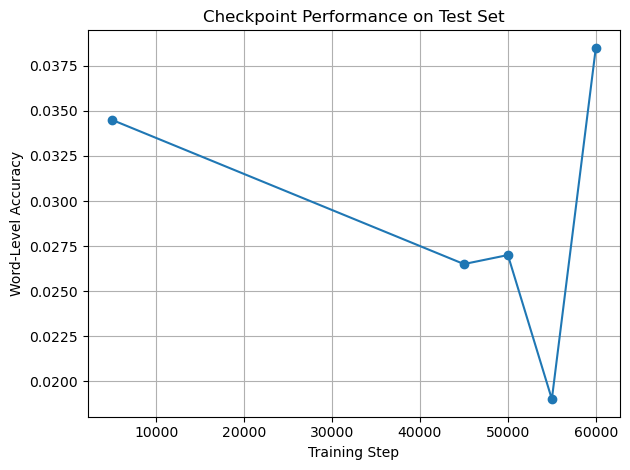

In [51]:
import glob
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# ─── 1) Rebuild the test DataLoader ─────────────────────────────────────────
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_tok    = CharacterLanguageModel.get_bert_tokenizer(os.path.join(args.bert_dir, "vocab.txt"))
typo_tok    = CharTokenizer()
test_set    = TypoDataset(os.path.join(args.data_dir, "test2k.tsv"), bert_tok, typo_tok, num_process=1)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=test_set.get_collate_fn()
)

# ─── 2) Helper to extract step number from filename ───────────────────────────
def step_from_path(path):
    m = re.search(r"ckpt-(\d+)\.pkl$", path)
    return int(m.group(1)) if m else -1

# ─── 3) Find all checkpoints ─────────────────────────────────────────────────
ckpt_dir   = os.path.join("results", "cim_base")
ckpt_paths = sorted(glob.glob(os.path.join(ckpt_dir, "ckpt-*.pkl")), key=step_from_path)

steps, accs = [], []

# ─── 4) Evaluate each checkpoint ─────────────────────────────────────────────
for ckpt_path in tqdm(ckpt_paths, desc="Evaluating checkpoints"):
    step = step_from_path(ckpt_path)
    # load weights
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model"])
    model.to(device).eval()

    golds, preds = [], []
    with torch.inference_mode():
        for batch in test_loader:
            ctx_ids  = batch["context_tokens"].to(device)
            ctx_mask = batch["context_attention_mask"].to(device)
            for i in range(ctx_ids.size(0)):
                typo = batch["typo"][i]
                gold = batch["correct"][i]
                pred = generate_with_edit_distance(
                    model,
                    ctx_ids[i:i+1], ctx_mask[i:i+1],
                    typo,
                    beam_size=args.num_beams,
                    C=args.edit_distance_weight,
                    max_length=64,
                    device=device
                )
                golds.append(gold)
                preds.append(pred)

    word_acc = np.mean([p == g for p, g in zip(preds, golds)])
    steps.append(step)
    accs.append(word_acc)
    print(f"Step {step:>6} → word‐accuracy: {word_acc*100:5.2f}%")

# ─── 5) Plot accuracy vs. training step ───────────────────────────────────────
plt.figure()
plt.plot(steps, accs, marker="o")
plt.xlabel("Training Step")
plt.ylabel("Word‐Level Accuracy")
plt.title("Checkpoint Performance on Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()
